# Algorithmes de tri rapides

Vous avez souvent vu dans les cours d'introduction des algorithmes pour trier un ensemble de valeurs. Ces tris étaient souvent quadratiques : le tri à bulles, le tri par insertion, le tri par sélection de minimum. Avec les notions vues cette année, de nouveaux algorithmes pour trier des valeurs vous sont ouverts. Il peut s'agir de structures de données, qui maintiennent des ensembles de valeurs triées, ou d'algorithmes qui vont souvent adopter une stratégie "diviser pour régner". Ces algorithmes ont généralement une complexité
$$
\Theta(n\log{n})
$$
soit à tous les coups, soit en moyenne. Dans ce cours nous ferons une petite revue de ces algorithmes, puis nous nous poserons la question de savoir s'il est possible d'avoir une meilleure complexité.

Pour tester les performances de nos algorithmes et nous donner une idée de leur complexité, nous aurons besoin des outils habituels.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import time
import numpy as np
import math
import random

In [2]:
def plot_array(array, log = False):
    if log:
        plt.semilogy(array)
    else:
        plt.plot(array)
    plt.show()

def perf(f, input, trials=10):
    res = []
    for i in input:
        t = time.time()
        for j in range(trials):
            f(i)
        res.append((time.time() - t)/trials)
    return np.array(res)

n = np.arange(2,1000)
nlogn = n * np.log2(n)
n2 = n*n

In [3]:
valeurs = [random.randrange(100) for i in range(20)]
print(valeurs)

[60, 7, 16, 2, 26, 48, 94, 94, 2, 97, 19, 92, 52, 75, 37, 22, 41, 99, 66, 1]


In [4]:
tri_inputs = [[random.randrange(100000) for _ in range(k)] for k in range(2,1000)]

## Structures de données permettant le tri

Les structures de données visent à organiser des données pour pouvoir facilement en insérer de nouvelles, les retrouver, et les parcourir. De nombreuses structures de données utilisent de façon sous-jacente un tri. Ces structures permettent donc facilement d'obtenir les éléments triés via une procédure simple d'insertion puis de parcours :

* insérer toutes les valeurs à trier dans la structure de données
* parcourir la structure de données pour obtenir les valeurs dans l'ordre

## Arbres binaires de recherche

Les arbres binaires de recherche permettent facilement d'obtenir les valeurs triées de manière récursive comme réalisé dans le code ci-dessous. L'idée est de récupérer les valeurs de gauche qui sont les plus petites, puis la valeur centrale, puis les valeurs de droite qui sont plus grande. En terme de complexité, on traverse tout l'arbre, c'est linéaire en le nombre de nœuds 

In [5]:
class ABRNode:
    def __init__(self, valeur):
        self.valeur = valeur
        self.gauche = None
        self.droite = None
        
class ABR:
    def __init__(self):
        self.racine = None
    
    def inserer_noeud(self, noeud, valeur):
        if noeud:
            if valeur < noeud.valeur:
                noeud.gauche = self.inserer_noeud(noeud.gauche, valeur)
            else:
                noeud.droite = self.inserer_noeud(noeud.droite, valeur)
            return noeud
        else:
            return ABRNode(valeur)
    
    def inserer(self, valeur):
        self.racine = self.inserer_noeud(self.racine, valeur)
        
    def tri_noeud(self, noeud, tab):
        if noeud:
            self.tri_noeud(noeud.gauche, tab)
            tab.append(noeud.valeur)
            self.tri_noeud(noeud.droite, tab)
        
    def tri(self):
        tab = []
        self.tri_noeud(self.racine, tab)
        return tab
        
def tri_abr(valeurs):
    abr = ABR()
    for val in valeurs:
        abr.inserer(val)
    return abr.tri()

In [6]:
print(valeurs)
print(sorted(valeurs))
print(tri_abr(valeurs))

[60, 7, 16, 2, 26, 48, 94, 94, 2, 97, 19, 92, 52, 75, 37, 22, 41, 99, 66, 1]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]


On peut maintenant examiner le temps d'éxécution sur un ensemble de tableaux de tailles croissantes, de 2 à 1000 valeurs.

In [7]:
abr_perf = perf(tri_abr, tri_inputs)

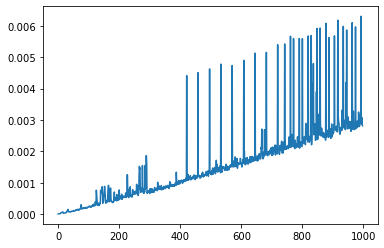

In [8]:
plot_array(abr_perf)

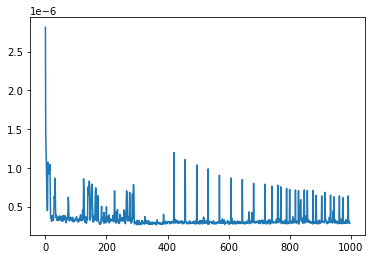

In [9]:
plot_array(abr_perf / nlogn)

Lorsqu'on fait le ratio entre notre temps d'éxécution et la fonction $n\log{n}$, on converge asymptotiquement vers vers une constante, ce qui tend à montrer que la complexité est bien $\Theta(n\log{n})$.

En analysant ce qui se passe :
* on commence par insérer n valeurs dans l'arbre
* si l'arbre est équilibré, une insertion coûte $\log{n}$
* on a donc un coup de $n\log{n}$ pour les insertions
* le parcours de l'arbre pour récupérer les valeurs triées parcourt chaque nœud une fois, donc est linéaire
* au total, ce sont les insertions qui sont prépondérantes

Notez que nous n'avons pas utilisé la technique des AVL pour forcer l'équilibre de l'arbre. Les résultats semblent montrer que malgré celà, l'insertion se fait en $\log{n}$, et donc qu'en remplissant un arbre avec une séquence de nombres aléatoires, l'arbre obtenu sera équilibré en moyenne.

### Skip List

Nous avons vu en TP la structure des Skip-lists. Cette structure augmente les listes chaînées en ajoutant des étages et en éliminant en moyenne un élément sur deux à chaque étage. Voyez le second TP si vous ne vous en souvenez plus. De même que pour les arbres il est très facile de récupérer les valeurs triées, puisque cette fois le niveau 0 de la skip-list est la liste chaînée de toutes les valeurs insérées triées.

In [10]:
class SkipCell:
    def __init__(self, value):
        # valeur
        self.value = value
        # suivants
        self.suivants = [None]
        # nombre de niveaux par pile ou face
        while random.randrange(2):
            self.suivants.append(None)
    
    def niveau(self):
        return len(self.suivants) - 1
        
class SkipList:
    def __init__(self):
        # création de la cellule bidon
        self.bidon = SkipCell(None)
        
    def inserer(self, value):
        # création de la nouvelle cellule
        nlle = SkipCell(value)
        
        # initialisation du curseur de parcours
        cell = self.bidon
        niveau = self.bidon.niveau()
        
        # ajustement du niveau de la cellule bidon si besoin
        for i in range(nlle.niveau() - cell.niveau()):
            cell.suivants.append(nlle)
        
        # insertion dans les niveaux existants
        while niveau >= 0:
            while cell.suivants[niveau] and cell.suivants[niveau].value < value:
                # avancer autant que possible
                cell = cell.suivants[niveau]
            # chainer au niveau courant si nécessaire
            if niveau <= nlle.niveau():
                nlle.suivants[niveau] = cell.suivants[niveau]
                cell.suivants[niveau] = nlle
            # descendre au niveau inférieur
            niveau -= 1
    
    def tri(self):
        # récupération du niveau 0 dans un tableau
        tab = []
        cell = self.bidon
        while cell.suivants[0]:
            cell = cell.suivants[0]
            tab.append(cell.value)
        return tab
    
def tri_skip_list(valeurs):
    sl = SkipList()
    for val in valeurs:
        sl.inserer(val)
    return sl.tri()

In [11]:
print(valeurs)
print(sorted(valeurs))
print(tri_skip_list(valeurs))

[60, 7, 16, 2, 26, 48, 94, 94, 2, 97, 19, 92, 52, 75, 37, 22, 41, 99, 66, 1]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]


In [12]:
sl_perf = perf(tri_skip_list, tri_inputs)

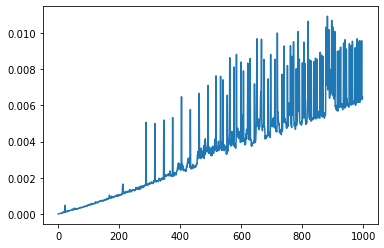

In [13]:
plot_array(sl_perf)

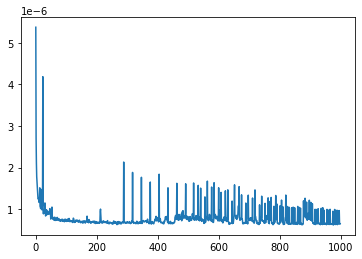

In [14]:
plot_array(sl_perf / nlogn)

Comme précédemment, le ratio avec la fonction $n\log{n}$ montre que cet algorithme de tri se comporte en moyenne avec la complexité $n\log{n}$. Comme nous l'avons vu en TD, l'insertion dans une skip-liste a une complexité $\log{n}$ et donc les $n$ insertions ont un coût $n\log{n}$. Le parcours final pour récupérer les valeurs triées est linéaire, donc comme pour le cas des arbres binaires de recherche, on a une complexité de l'ordre de $n\log{n}$

### Tas binaire

Le tas binaire n'est pas utilisé dans le même contexte que les structures précédentes, il sert à garder en permanence sous la main le maximum ou le minimum (ici) d'un ensemble de valeurs. En insérant toutes les valeurs, et en retirant ensuite itérativement le minimum on obtient toutes les valeurs dans l'ordre.

In [15]:
class Tas:
    def __init__(self):
        # un tas est réalisé dans un tableau
        self.tab = []
        
    def parent(self, i):
        return (i-1)//2
    
    def min_child(self, i):
        # enfant de valeur minimale d'un noeud
        if 2*i+2 < len(self.tab) and self.tab[2*i+1] > self.tab[2*i+2]:
            return 2*i+2
        return 2*i+1
    
    def inserer(self, valeur):
        # initialisation du curseur pour remonter dans l'arbre
        index = len(self.tab)
        parent = self.parent(index)
        # ajout d'un emplacement dans l'arbre
        self.tab.append(None)
        # décalage des valeurs jusqu'à trouver la hauteur du nouvel élément
        while index > 0 and self.tab[parent] > valeur:
            self.tab[index] = self.tab[parent]
            index = parent
            parent = self.parent(index)
        self.tab[index] = valeur
        
    def retirer(self):
        # sauvegarde du minimum
        result = self.tab[0]
        # réduction du tableau et sauvegarde de la valeur finale
        valeur = self.tab.pop()
        # descente dans l'arbre pour trouver la place de l'élément final
        if len(self.tab) > 0:
            index = 0
            child = self.min_child(index)
            while child < len(self.tab) and self.tab[child] < valeur:
                self.tab[index] = self.tab[child]
                index = child
                child = self.min_child(index)
            self.tab[index] = valeur
        return result
    
    def vider(self):
        # récupération de tous les éléments triés dans un tableau
        tab = []
        while len(self.tab) > 0:
            tab.append(self.retirer())
        return tab

def tri_tas(valeurs):
    tas = Tas()
    for val in valeurs:
        tas.inserer(val)
    return tas.vider()

In [16]:
print(sorted(valeurs))
print(tri_tas(valeurs))

[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]


In [17]:
tas_perf = perf(tri_tas, tri_inputs)

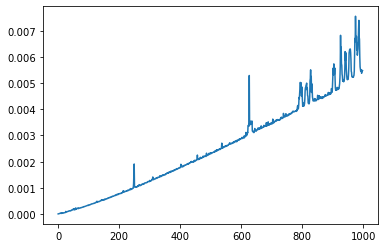

In [18]:
plot_array(tas_perf)

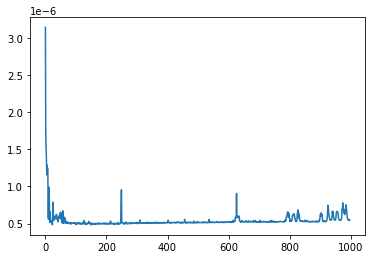

In [19]:
plot_array(tas_perf / nlogn)

Un tas est enregistré dans un tableau, mais il est structuré en arbre binaire équilibré. Chaque insertion coûte au plus une traversée de bas en haut, et un retrait une traversée de haut en bas. Les deux opérations sont donc de complexité $O(\log{n})$. En réalisant $n$ insertions puis $n$ retraits, on a donc une complexité
$O(n\log{n})$ également.

## Algorithmes diviser pour régner

Les deux principaux algorithmes de type diviser pour régner sont le quicksort, et le tri fusion, appelé merge sort pour les anglophones. Ces deux algorithmes misent sur le même principe : séparer les données en deux parties à trier indépendamment. Le quicksort travaille sur la séparation des données, mais n'a plus rien à faire une fois les deux parties triées, alors que le tri fusion ne fait rien de compliqué pour séparer les données, mais travaille plus pour le regroupement de deux tableaux triés.

### Quicksort

Le quicksort, ou tri rapide, est un algorithme de tri défini sur des tableaux. Le tri peut être réalisé en place, c'est à dire sans créer de nouveau tableau, et donc en utilisant juste quelques variables supplémentaires en mémoire. Le principe de cet algorithme est d'utiliser un *pivot* : une valeur dans le tableau est choisie, et en un balayage du tableau, il est réorganisé pour que toutes les valeurs plus petites que le pivot soient dans la partie gauche, et toutes les valeurs plus grandes que le pivot soient à droite. Le pivot, lui, finit à sa place dans le tableau.

In [20]:
def alea_pivot(tab, debut, fin):
    # tirage aléatoire de l'indice de la case pivot
    ip = random.randrange(debut, fin)
    # replacement du pivot au début
    tab[debut],tab[ip] = tab[ip],tab[debut]
    # initialisation du balayage
    inf = debut + 1
    sup = fin - 1
    while inf <= sup:
        # prochain indice supérieur au pivot en partant du début
        while inf <= sup and tab[inf] <= tab[debut]:
            inf += 1
        # prochain indice inférieur au pivot en partant de la fin
        while inf <= sup and tab[sup] > tab[debut]:
            sup -= 1
        # échange des deux si utile et possible
        if inf < sup:
            tab[inf], tab[sup] = tab[sup], tab[inf]
            inf += 1
            sup -= 1
    # placement du pivot à sa place
    tab[debut], tab[inf-1] = tab[inf-1], tab[debut]
    # retour de la position du pivot
    return inf-1

In [21]:
exemple = valeurs[:]
print("tableau initial :")
print(exemple)
position = alea_pivot(exemple, 0, len(exemple))
print("le pivot choisi est %d" % exemple[position])
print("tableau final :")
print(exemple)

tableau initial :
[60, 7, 16, 2, 26, 48, 94, 94, 2, 97, 19, 92, 52, 75, 37, 22, 41, 99, 66, 1]
le pivot choisi est 52
tableau final :
[37, 7, 16, 2, 26, 48, 1, 41, 2, 22, 19, 52, 60, 75, 92, 97, 94, 99, 66, 94]


Une fois le pivot réalisé sur le tableau, les deux portions du tableau à droite et à gauche du tableau peuvent être récursivement triées indépendamment. Notez que dans le code ci-dessous, une copie du tableau est réalisée pour éviter de perturber les données du test de performances, mais en ne faisant pas la copie, le tri est réalisé en place dans le tableau fourni.

In [22]:
def qsort_aux(tab, debut, fin):
    # si la portion de tableau a moins de deux valeurs, elle est déjà triée
    if fin - debut > 1:
        # pivot
        mid = alea_pivot(tab, debut, fin)
        # tri indépendant des deux moitiés de part et d'autre du pivot
        qsort_aux(tab, debut, mid)
        qsort_aux(tab, mid+1, fin)
              
def quick_sort(tab):
    # recopie pour les besoin de l'exemple mais en pratique inutile
    cpy = tab[:]
    qsort_aux(cpy, 0, len(cpy))
    return cpy 

In [23]:
print(sorted(valeurs))
print(quick_sort(valeurs))

[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]


In [24]:
qsort_perf = perf(quick_sort, tri_inputs)

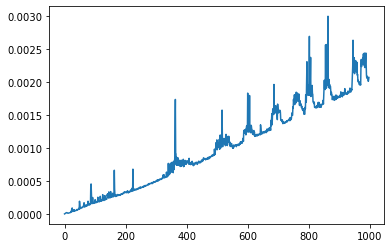

In [25]:
plot_array(qsort_perf)

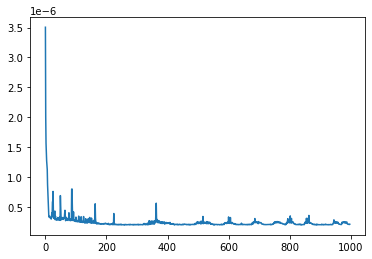

In [26]:
plot_array(qsort_perf / nlogn)

On constate à nouveau une complexité $n\log{n}$. Cette complexité s'explique par le fait qu'en moyenne, le pivot choisi aléatoirement est au milieu du tableau. Ainsi en triant récursivement les portions à droite et à gauche du tableau, on a une complexité de la forme :

$$
T(n) = 2T\left(\frac{n}{2}\right) + \Theta(n),
$$

où $\Theta(n)$ est la complexité du pivot. En appliquant le Master Theorem sur cette expression, du fait que $\log_2{2} = 1$, on a alors $T(n) = \Theta(n\log{n})$. 

Notez bien que ce n'est valable qu'en moyenne, et ça se vérifie sur les courbes de performance ci-dessus. Dans le cas où le pivot tombe mal, c'est à dire sur le minimum ou le maximum du tableau, alors la découpe n'est pas équilibrée, et dans le pire cas la complexité devient :

$$
\begin{aligned}
    T(n) &= T(n-1) + T(0) + \Theta(n)\\
         &= T(n-2) + T(0) + \Theta(n-1) + T(0) + \Theta(n)\\
         &= \ldots\\
         &= (n+1)T(0) + \sum_{i=1}^n\Theta(i)\\
         &= \Theta(n^2)
\end{aligned}
$$

### Tri fusion

Le tri fusion est un tri conçu pour fonctionner sur des listes chaînées. Il ne peut pas se faire en place dans un tableau, mais a l'intérêt de ne pas avoir besoin d'accéder aux données par indice (on parle d'accès aléatoire). Le principe du tri fusion est de séparer la liste initiale en deux listes de tailles égales (autant que possible). Ces listes sont triées indépendamment. Ensuite, la fusion prend en entrée deux listes chaînées triées, et sort la liste chaînée triée qui regroupe les deux. Cette étape va itérativement examiner els têtes des deux listes en entrée, et prélever le minimum de ces têtes pour l'introduire dans la liste résultat.

In [27]:
def fusion(tab1,tab2):
    # résultat
    res = []
    # têtes courantes des deux listes en entrée
    i1 = 0
    i2 = 0
    while i1 < len(tab1) and i2 < len(tab2):
        # aucune des deux listes n'est vide
        if tab1[i1] < tab2[i2]:
            # le minimum est en tête de tab1, on le prend et on avance
            res.append(tab1[i1])
            i1 += 1
        else:
            # le minimum est en tête de tab2, on le prend et on avance
            res.append(tab2[i2])
            i2 += 1
    # au moins une liste est vide, le reste de l'autre est à ajouter à la fin
    res.extend(tab1[i1:])
    res.extend(tab2[i2:])
    return res

In [28]:
fusion([1,3,5,7], [2,4,6,8])

[1, 2, 3, 4, 5, 6, 7, 8]

In [29]:
def tri_fusion(tab):
    # une liste de moins de deux éléments est triée
    mid = len(tab)//2
    if mid > 0:
        # séparation de la liste en deux listes de tailles quasi égales
        # tri indépendant des deux moitiés
        t1 = tri_fusion(tab[:mid])
        t2 = tri_fusion(tab[mid:])
        # fusion des moitiés triées
        return fusion(t1,t2)
    return tab[:]

In [30]:
print(sorted(valeurs))
print(tri_fusion(valeurs))

[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]


In [31]:
fusion_perf = perf(tri_fusion, tri_inputs)

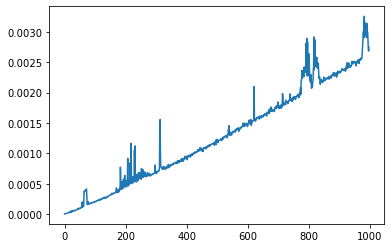

In [32]:
plot_array(fusion_perf)

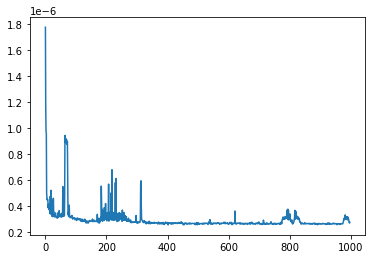

In [33]:
plot_array(fusion_perf/nlogn)

De nouveau, la complexité est de l'ordre de $n\log{n}$. En effet, le problème est ici séparé en deux sous problèmes résoluts indépendamment (on coupe la liste initale en deux), puis on réalise la fusion des deux listes triées, ce qui demande de parcourir intégralement les deux moitiés, et a donc une complexité $\Theta(n)$. Nous avons donc comme pour le quicksort la complexité exprimable sous la forme :

$$
T(n) = 2T\left(\frac{n}{2}\right) + \Theta(n),
$$

ce qui donne avec le Master Theorem une complexité $T(n) = \Theta(n\log{n})$.

## Complexité optimale d'un algorithme de tri utilisant des comparaisons

Dans tout ce qui a précédé, nous avons présenté des algorithmes qui triaient des données, et tous offraient une complexité $n\log{n}$. Il est donc légitime de se demander s'il serait possible d'imaginer un algorithme avec une meilleur complexité. Nous allons donc montrer ici que la complexité optimale d'un algorithme de tri qui utilise des comparaisons est $\Theta(n\log{n})$.

### Arbre de décision

Tout algorithme de tri fondé sur des comparaisons peut être modélisé par un arbre de décision. Chaque comparaison réalisée permet d'orienter l'algorithme vers le bon résultat. Une comparaison est un test binaire : elle peut avoir deux résultats, vrai ou faux. Dans un arbre de décision, chaque comparaison est un nœud de l'arbre. Les sous-arbres en dessous correspondent à la suite de l'algorithme selon que la comparaison est vraie ou fausse. Par exemple, l'arbre ci-dessous permet de réaliser le tri d'un tableau de taille 3. Lorsque le test est vrai, l'algorithme descend à gauche, sinon il descent à droite.

<center><img src="decision.svg" style="width : 80% ; margin : 40px ;"/></center>

Par exemple, si on applique cet arbre pour trier le tableau `[7, 1, 6]`, on obtient :

<center><img src="decision_7-1-6.svg" style="width : 80% ; margin : 40px ;"/></center>

La complexité de l'algorithme en terme de nombre de comparaisons est donc la longueur du chemin depuis la racine de l'arbre jusqu'à la feuille donnant l'ordre dans lequel remettre les éléments du tableau. **Le meilleur algorithme possible pour trier un tableau doit donc minimiser la longueur du plus long chemin de la racine à une feuille de l'arbre de décision**.

### Hauteur de l'arbre de décision

Pour que l'arbre de décision soit en mesure de trier correctement un tableau, il faut qu'il puisse avoir pour résultat n'importe quelle permutation du tableau initial. Si $n$ est la taille du tableau, une permutation peut être générée en choisissant un premier élément parmi les $n$ éléments du tableau (il y a donc $n$ possibilités). Le second élément peut ensuite être choisi parmi les $n-1$ éléments restants (il y a donc $n-1$ possibilités) et ainsi de suite. Le nombre de permutations est donc $n \times (n-1) \times (n-2) \times \ldots \times 1 = n!$. **L'arbre de décision a donc $n!$ feuilles au minimum**.

Pour être le moins profond possible, un arbre binaire doit être le plus équilibré possible. Un arbre binaire équilibré de hauteur 2 a 2 feuilles. À la hauteur 3 il a 4 feuilles. À la hauteur $h$, il a $2^{h-1}$ feuilles. Nous cherchons donc $h$ tel que $2^{h-1} = n!$, et donc $h = \log_2{(n!)} + 1$. En utilisant [la formule de Stirling](https://fr.wikipedia.org/wiki/Formule_de_Stirling) on obtient que :

$$
\log_2{(n!)} = \Theta(n\log_2{n}).
$$

Ce qui nous donne donc que la hauteur minimale d'un arbre de décision permettant de trier un tableau de taille $n$ est de l'ordre de $n\log{n}$. Il n'est donc pas possible de faire un algorithme de tri utilisant uniquement des comparaisons qui aurait dans le pire des cas une complexité meilleure que $n\log{n}$.

Les algorithmes présentés précédemment réalisant cette complexité sont donc **optimaux**, c'est à dire qu'ils réalisent la meilleure complexité possible pour le problème du tri d'un tableau de taille $n$.

## Tri par radical (radix sort)

Dans la section précédente, nous avons vu que s'il n'utilise que des comparaisons, un algorithme de tri ne peut pas avoir une complexité meilleure que $n\log{n}$. La comparaison n'est pas la seule façon de trier un tableau. Le tri par radical par exemple est un algorithme qui n'utilise pas que des comparaisons. Cet algorithme décompose les éléments à trier sur une base. Ici, nous allons utiliser la décomposition des nombres en base 10, chiffre par chiffre. Nous allons donc avoir besoin de fonctions pour déterminer le nombre de chiffres (digits) d'un nombre et extraire chaque chiffre du nombre.

In [34]:
def digit(n, i):
    return (n // (10**i)) % 10

def digit_size(n):
    if n == 0:
        return 0
    return int(math.log10(n))+1

L'algorithme consiste donc à itérativer trier les nombres en fonction d'un de leurs chiffres. La clé est que si deux nombres ont le même chiffre, leur ordre est préservé. On va donc d'abord trier les nombres en fonction du chiffre des unités, ensuite des dizaines, puis les centaines et ainsi de suite. Lorsque tous les chiffres auront été traités, les nombres seront triés.

Pour trier les nombres en fonction d'un chiffre, on commence par une première phase de comptage qui détermine nombre d'éléments du tableau ayant ce chiffre à la position courante. Une fois que les comptes sont faits, les nombres ayant 0 doivent être placés, puis ceux ayant le 1 et ainsi de suite. Connaissant le nombre de nombres ayant 0, on sait à partir de quel indice doivent se placer les nmobres ayant un 1. Connaissant le nombre de 1 également, on sait à partir d'où se placent les 2, et ainsi de suite. On peut donc placer chaque nombre dans sa zone lors d'une seconde passe, tout en préservant l'ordre initial des nombres ayant le même chiffre.

In [35]:
def radix_sort(t):
    # recopie falcultative du tableau en entrée pour les besoins de l'exemple
    cpy = t[:]
    # un tableau annexe pour réordonner les éléments
    buffer = t[:]
    # nombre de chiffres du plus grand nombre du tableau
    iteration_count = max(digit_size(n) for n in t)
    # chiffre courant
    digit_index = 0
    for _ in range(iteration_count):
        # initialisation des décomptes par chiffre
        counts = [0 for i in range(10)]
        for n in cpy:
            # extraction du chiffre courant, et incrémentation du compteur correspondant
            d = digit(n, digit_index)
            counts[d] += 1
        # calcul des indices de départ des plages de chaque chiffre dans le tableau final
        for i in range(1,10):
            counts[i] += counts[i-1]
        counts = [0] + counts[:-1]
        # placement de tous les nombres à leur place dans le tableau annexe
        for n in cpy:
            # extraction du chiffre pertinent
            d = digit(n, digit_index)
            # placement dans sa zone au prochain indice disponible
            buffer[counts[d]] = n
            # incrémentation du prochain indice disponible pour la zone
            counts[d] += 1
        # échange du tableau annexe et du tableau initial
        cpy, buffer = buffer, cpy
        # passage au chiffre suivant
        digit_index += 1
    return cpy

In [36]:
print(valeurs)
print(sorted(valeurs))
print(radix_sort(valeurs))

[60, 7, 16, 2, 26, 48, 94, 94, 2, 97, 19, 92, 52, 75, 37, 22, 41, 99, 66, 1]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]
[1, 2, 2, 7, 16, 19, 22, 26, 37, 41, 48, 52, 60, 66, 75, 92, 94, 94, 97, 99]


Ce tri n'utilise pas de comparaisons. à la place, il utilise une opération qui sépare les nombres en 10 paquets en fonction d'un de leur chiffre. Il n'est donc pas affecté par le théorème de la partie précédente qui donne la complexité optimale d'un algorithme de tri utilisant des comparaisons. Voyons donc ses performances.

In [37]:
radix_perf = perf(radix_sort, tri_inputs)

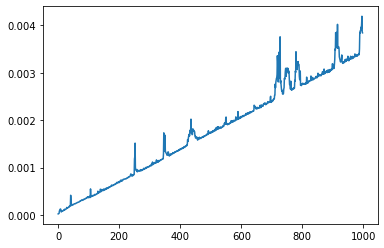

In [38]:
plot_array(radix_perf)

Si on fait le ratio entre $n\log{n}$ et nos performances, on voit qu'il nous reste un terme qui ressemble à $\log{n}$.

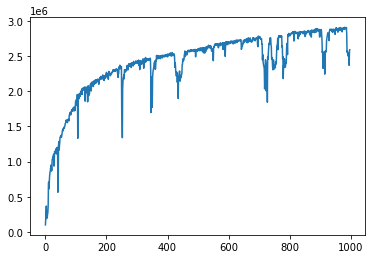

In [39]:
plot_array(nlogn / radix_perf)

En faisant le ratio avec $n$, on voit cette fois que le ratio tend vers une constante, et il semble donc que notre algorithme soit linéaire !

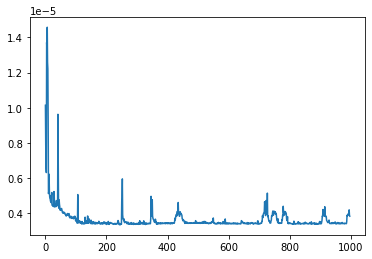

In [40]:
plot_array(radix_perf / n)

### Pour mitiger les choses

Le tri par radical est linéaire, mais il y a un piège. Il est linéaire en le nombre de chiffres des nombres fournis en entrée. Du coup si nous avons dix milliards de nombres à 4 chiffres à trier, il fera 4 passes linéaires sur le tableau et sera linéaire. Par contre, si on lui demande de trier trois nombres, dont un a 10 milliards de chiffres, il fera 10 milliards de passes sur le tableau.

Si on se demande donc maintenant quelle est la complexité du tri par radical pour trier un tableau de $n$ nombres **distincts**, il faut donc se demander le nombre de chiffres nécessaires pour avoir $n$ nombres distincts. Pour 10 nombres, il faut 1 chiffre au minimum : les nombres de 0 à 9 sont 10. Au delà de 10 nombres, et jusqu'à 100 nombres, il faut 2 chiffres, jusqu'à 99. Trois chiffres permettent d'aller jusqu'à $n = 1000$, et plus généralement $k$ chiffres permettent d'aller jusqu'à $10^k$ nombres. En prenant cette formule dans l'autre sens, pour avoir $n$ nombres distincts il faudra donc au minimum $\log_{10}(n)$ chiffres.

Ainsi, pour trier $n$ nombres distincts, il faudra donc au minimum $\log_{10}n$ itérations linéaires sur un tableau de taille $n$, soit une complexité de ... $n\log{n}$.